# The Kolmogorov Backward Equation

In addition to what’s in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

## Overview

As models become more complex, deriving analytical representations of the
Markov semigroup $(P_t)$ becomes harder.

This is analogous to the idea that solutions to continuous time models often
lack analytical solutions.

For example, when studying deterministic paths in continuous time,
infinitesimal descriptions ([ODEs](https://en.wikipedia.org/wiki/Ordinary_differential_equation) and [PDEs](https://en.wikipedia.org/wiki/Partial_differential_equation)) are often more intuitive and easier
to write down than the associated solutions.

(This is one of the shining insights of mathematics, beginning with the work
of great scientists such as Isaac Newton.)

We will see in this lecture that the same is true for continuous time Markov
chains.

To help us focus on intuition in this lecture, rather than technicalities, the state space is assumed to be finite, with $|S|=n$.

Later we will investigate the case where $|S| = \infty$.

We will use the following imports

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit

from scipy.linalg import expm
from scipy.stats import binom

(sdji)=
## State Dependent Jump Intensities

As we have seen, continuous time Markov chains jump between states, and hence can 
have the form

$$
    X_t = \sum_{k \geq 0} Y_k \mathbb 1\{J_k \leq t < J_{k+1}\}
    \qquad (t \geq 0)
$$ 

where $(J_k)$ are jump times and $(Y_k)$ are the states at each jump.

(We are assuming that $J_k \to \infty$ with probability one, so that $X_t$ is well
defined for all $t \geq 0$, but this is always true for when holding times are exponential and the state space is finite.)

In the {doc}`previous lecture <markov_prop>`, 

* the sequence $(Y_k)$ was drawn from a Markov matrix $K$ and called the embedded jump chain, while
* the holding times $W_k := J_k - J_{k-1}$ were IID and Exp$(\lambda)$ for some
constant jump intensity $\lambda$.

In this lecture, we will generalize by allowing the jump intensity to vary
with the state.

This difference sounds minor but in fact it will allow us to reach full generality
in our description of continuous time Markov chains, as
clarified below.

### Motivation

As a motivating example, recall {ref}`the inventory model <inventory_dynam>`,
where we assumed that the wait time for the next customer was equal
to the wait time for new inventory.

This assumption was made purely for convenience and seems unlikely to hold true.

When we relax it, the jump intensities depend on the state.

(jumpchainalgo)=
### Jump Chain Algorithm

We start with three primitives

1. An initial condition $\psi$, 
1. a Markov matrix $K$ on $S$ satisfying $K(x, x) = 0$ for all $x \in S$
   and
1. a function $\lambda$ mapping $S$ to $(0, \infty)$.

The process $(X_t)$ 

* starts at state $x$, draw from $\psi$,
* waits there for an exponential time $W$ with rate $\lambda(x)$ and then
* updates to a new state $y$ drawn from $K(x, \cdot)$.

Now we take $y$ as the new state for the process and repeat.

Here is the same algorithm written more explicitly: 

```{prf:algorithm} Jump Chain Algorithm
:label: ejc_algo

**Inputs** $\psi \in \dD$, rate function $\lambda$, Markov matrix $K$

**Outputs** Markov chain $(X_t)$

1. Draw $Y_0$ from $\psi$, set $J_0 = 0$ and $k=1$.
1. Draw $W_k$ independently from Exp$(\lambda(Y_{k-1}))$.
1. Set $J_k = J_{k-1} + W_k$.
1. Set $X_t = Y_{k-1}$ for $t$ in $[J_{k-1}, J_k)$.
1. Draw $Y_k$ from $K(Y_{k-1}, \cdot)$.
1. Set $k = k+1$ and go to step 2.

```

The sequence $(W_k)$ is drawn as an IID sequence and $(W_k)$ and $(Y_k)$ are
drawn independently.

The restriction $K(x,x) = 0$ for all $x$ implies that $(X_t)$ actually jumps at each jump time.


## Computing the Semigroup

For the jump process $(X_t)$ with time varying intensities described in the
jump chain algorithm, calculating the Markov semigroup is not a trivial exercise.

The approach we adopt is

1. Use probabilistic reasoning to obtain an integral equation that the
   semigroup must satisfy.
1. Convert the integral equation into a differential equation that is easier
   to work with.
1. Solve this differential equation to obtain the Markov semigroup $(P_t)$.

The differential equation in question has a special name:  the Kolmogorov backward equation.


### An Integral Equation


Here is the first step in the sequence listed above.


```{prf:lemma} An Integral Equation

The semigroup $(P_t)$ of the jump chain with rate function $\lambda$ and Markov matrix $K$ obeys the integral equation 

$$
    P_t(x, y) = e^{-t \lambda(x)} I(x, y)
    + \lambda(x) 
      \int_0^t (K P_{t-\tau})(x, y) e^{- \tau \lambda(x)} d \tau
$$ (kbinteg)

for all $t \geq 0$ and $x, y$ in $S$.
```

Here $(P_t)$ is the Markov semigroup of $(X_t)$, the process constructed via
{prf:ref}`ejc_algo`, while $K P_{t-\tau}$ is the matrix product of $K$ and
$P_{t-\tau}$.

```{prf:proof}

Conditioning implicitly on $X_0 = x$, the semigroup $(P_t)$ must satisfy 

$$
    P_t(x, y) 
    = \PP\{X_t = y\}
    = \PP\{X_t = y, \; J_1 > t \}
        + \PP\{X_t = y, \; J_1 \leq t \}
$$ (pt_split)

Regarding the first term on the right hand side of {eq}`pt_split`, we have 

$$
    \PP\{X_t = y, \; J_1 > t \}
        = I(x, y) P\{J_1 > t \}
        = I(x, y) e^{- t \lambda(x)}
$$ (pt_first)

where $I(x, y) = \mathbb 1\{x = y\}$.

For the second term on the right hand side of {eq}`pt_split`, we have 

$$
    \PP\{X_t = y, \; J_1 \leq t \}
    = \EE 
        \left[
            \mathbb 1\{J_1 \leq t\} \PP\{X_t = y \,|\, W_1, Y_1\}
        \right]
    = \EE 
        \left[
            \mathbb 1\{J_1 \leq t\} P_{t - J_1} (Y_1, y) 
        \right]
$$

Evaluating the expectation and using the independence of $J_1$ and $Y_1$, this becomes

$$
\begin{aligned}
    \PP\{X_t = y, \; J_1 \leq t \}
    & = \int_0^\infty
            \mathbb 1\{\tau \leq t\}
            \sum_z K(x, z) P_{t - \tau} (z, y)  \lambda(x) e^{-\tau \lambda(x)} 
            d \tau
        \\
    & = \lambda(x)
            \int_0^t
            \sum_z K(x, z) P_{t - \tau} (z, y)  e^{-\tau \lambda(x)} 
            d \tau
\end{aligned}
$$

Combining this result with {eq}`pt_split` and {eq}`pt_first` gives
{eq}`kbinteg`.
```


### Kolmogorov's Differential Equation

We have now confirmed that the semigroup $(P_t)$ associated with the jump
chain process $(X_t)$ satisfies {eq}`kbinteg`.

Equation {eq}`kbinteg` is important but we can simplify it further without
losing information by taking the time derivative.

This leads to our main result for the lecture


```{prf:theorem} Kolmogorov Backward Equation

The semigroup $(P_t)$ of the jump chain with rate function $\lambda$ and Markov matrix $K$ satisfies the **Kolmogorov backward equation**

$$
    P'_t = Q P_t 
    \quad \text{where } \;
    Q(x, y) := \lambda(x) (K(x, y) - I(x, y))
$$ (kolbackeq)
```

The derivative on the left hand side of {eq}`kolbackeq` is taken element by
element, with respect to $t$, so that

$$
    P'_t(x, y) = \left( \frac{d}{dt} P_t(x, y) \right)
    \qquad ((x, y) \in S \times S)
$$

The proof that differentiating {eq}`kbinteg` yields {eq}`kolbackeq` is an
important exercise (see below).



### Exponential Solution

The Kolmogorov backward equation is a matrix-valued differential equation.

Recall that, for a scalar differential equation $y'_t = a y_t$ with constant
$a$ and initial condition $y_0$, the solution is $y_t = e^{ta} y_0$.

This, along with $P_0 = I$, encourages us to guess that the solution to
Kolmogorov's backward equation {eq}`kolbackeq` is

$$
    P_t = e^{t Q} 
$$ (expsol)

where the right hand side is the [matrix exponential](https://en.wikipedia.org/wiki/Matrix_exponential), with definition 

$$
    e^{tQ} 
    = \sum_{k \geq 0} \frac{1}{k!} (tQ)^k
    = I + tQ + \frac{t^2}{2!} Q^2 + \cdots
$$ (expofun)

Working element by element, it is not difficult to confirm that 
the derivative of the exponential function $t \mapsto e^{tQ}$ is

$$
    \frac{d}{dt} e^{t Q} = Q e^{t Q} = e^{t Q} Q
$$ (expoderiv)

Hence, differentiating {eq}`expsol` gives $P'_t = Q e^{t Q} = Q P_t$, which
convinces us that the exponential solution satisfies {eq}`kolbackeq`. 

Notice that our solution

$$
    P_t = e^{t Q} 
    \quad \text{where } \;
    Q(x, y) := \lambda(x) (K(x, y) - I(x, y))
$$  (psolq)

for the semigroup of the jump process $(X_t)$ associated with the jump matrix
$K$ and the jump intensity function $\lambda \colon S \to (0, \infty)$ is
consistent with our earlier result.

In particular, we {ref}`showed <consjumptransemi>` that, for the model with
constant jump intensity $\lambda$, we have $P_t = e^{t \lambda (K - I)}$.

This is obviously a special case of {eq}`psolq`.



## Properties of the Solution

Let's investigate further the properties of the exponential solution.

### Checking the Transition Semigroup Properties

While we have confirmed that $P_t = e^{t Q}$ solves the Kolmogorov backward
equation, we still need to check that this solution is a Markov semigroup.

```{prf:lemma} From Jump Chain to Semigroup
:label: jctosg

Let $\lambda$ map $S$ to $\RR_+$ and let $K$ be a Markov matrix on $S$.
If $P_t = e^{t Q}$ for all $t \geq 0$, where
$Q(x, y) = \lambda(x) (K(x, y) - I(x, y))$, then $(P_t)$ is a Markov
semigroup on $S$.
```


```{prf:proof}
Observe first that $Q$ has zero row sums, since

$$
    \sum_y Q(x, y) 
    = \lambda(x) \sum_y (K(x, y) - I(x, y))
    = 0
$$

As a small exercise, you can check that, with $1$
representing a column vector of ones, the following is true

$$
    Q \text{ has zero row sums }
    \iff
    Q^k 1 = 0 \text{ for all } k \geq 1
$$ (zrsnec)

This implies that $Q^k 1 = 0$ for all $k$ and, as a result, for any $t \geq
0$,

$$
    P_t 1
    = e^{tQ} 1
    = I1 + tQ1 + \frac{t^2}{2!} Q^2 1 + \cdots
    = I1 = 1
$$

In other words, each $P_t$ has unit row sums. 

Next we check nonnegativity of all elements of $P_t$ (which can easily fail for
matrix exponentials).

To this end, adopting an argument from {cite}`stroock2013introduction`, we
set $m := \max_x \lambda(x)$ and $\hat P := I + Q / m$.

It is not difficult to check that $\hat P$ is a Markov matrix and $Q = m( \hat
P - I)$.

Recalling that, for matrix exponentials, $e^{A+B} = e^A e^B$ whenever $AB =
BA$, we have

$$
    e^{tQ} 
    = e^{tm (\hat P - I)} 
    = e^{-tm I} e^{tm \hat P}
    = e^{-tm} 
        \left( 
            I + tm \hat P + \frac{(tm)^2}{2!} \hat P^2 + \cdots
        \right)
$$

It is clear from this representation that all entries of $e^{tQ}$ are
nonnegative.

Finally, we need to check the continuity condition $P_t(x, y) \to I(x,y)$ as
$t \to 0$, which is also part of the definition of a Markov semigroup.
This is immediate, in the present case, because the exponential function is
continuous, and hence $P_t = e^{tQ} \to e^0 = I$.
```

We can now be reassured that our solution to the Kolmogorov backward equation
is indeed a Markov semigroup.


### Uniqueness

Might there be another, entirely different Markov semigroup that also
satisfies the Kolmogorov backward equation?

The answer is no:  linear ODEs in finite dimensional vector space with
constant coefficients and fixed initial conditions (in this case $P_0 = I$)
have unique solutions.

In fact it's not hard to supply a proof --- see the exercises.



## Application: The Inventory Model

Let us look at a modified version of the inventory model where jump
intensities depend on the state.

In particular, the wait time for new inventory will now be exponential at rate
$\gamma$.

The arrival rate for customers will still be denoted by $\lambda$ and allowed
to differ from $\gamma$.

For parameters we take

In [3]:
α = 0.6
λ = 0.5
γ = 0.1
b = 10

Our plan is to investigate the distribution $\psi_T$ of $X_T$ at $T=30$.

We will do this by simulating many independent draws of $X_T$ and
histogramming them.

(In the exercises you are asked to calculate $\psi_T$ a different way, via
{eq}`psolq`.)

In [4]:
@njit
def draw_X(T, X_0, max_iter=5000):
    """
    Generate one draw of X_T given X_0.
    """

    J, Y = 0, X_0
    m = 0

    while m < max_iter:
        s = 1/γ if Y == 0 else 1/λ
        W = np.random.exponential(scale=s)  # W ~ E(λ)
        J += W
        if J >= T:
            return Y
        # Otherwise update Y
        if Y == 0:
            Y = b
        else:
            U = np.random.geometric(α)
            Y = Y - min(Y, U)
        m += 1


@njit
def independent_draws(T=10, num_draws=100):
    "Generate a vector of independent draws of X_T."

    draws = np.empty(num_draws, dtype=np.int64)

    for i in range(num_draws):
        X_0 = np.random.binomial(b+1, 0.25)
        draws[i] = draw_X(T, X_0)

    return draws

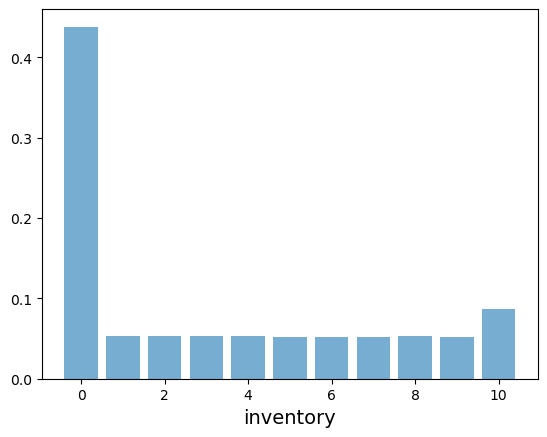

In [5]:
T = 30
n = b + 1
draws = independent_draws(T, num_draws=100_000)
fig, ax = plt.subplots()

ax.bar(range(n), [np.mean(draws == i) for i in range(n)], width=0.8, alpha=0.6)
ax.set_xlabel("inventory", fontsize=14)

plt.show()

If you experiment with the code above, you will see that the large amount of
mass on zero is due to the low arrival rate $\gamma$ for inventory.




## Exercises

````{exercise}
:label: kolmogorov-bwd-1

In the discussion above, we generated an approximation of $\psi_T$ when
$T=30$, the initial condition is Binomial$(n, 0.25)$ and parameters
are set to

```ipython3
α = 0.6
λ = 0.5
γ = 0.1
b = 10
```

The calculation was done by simulating independent draws and histogramming.

Try to generate the same figure using {eq}`psolq` instead, modifying code from
{doc}`our lecture <markov_prop>` on the Markov property.
````

```{solution-start} kolmogorov-bwd-1
:class: dropdown
```

Here is one solution:

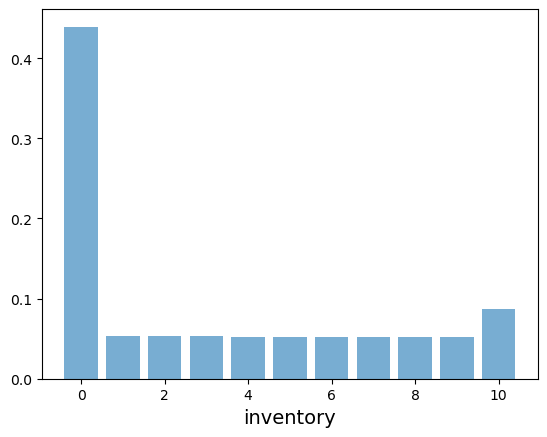

In [6]:
α = 0.6
λ = 0.5
γ = 0.1
b = 10

states = np.arange(n)
I = np.identity(n)

# Embedded jump chain matrix
K = np.zeros((n, n))
K[0, -1] = 1
for i in range(1, n):
    for j in range(0, i):
        if j == 0:
            K[i, j] = (1 - α)**(i-1)
        else:
            K[i, j] = α * (1 - α)**(i-j-1)

# Jump intensities as a function of the state
r = np.ones(n) * λ
r[0] = γ

# Q matrix
Q = np.empty_like(K)
for i in range(n):
    for j in range(n):
        Q[i, j] = r[i] * (K[i, j] - I[i, j])

def P_t(ψ, t):
    return ψ @ expm(t * Q)

ψ_0 = binom.pmf(states, n, 0.25)
ψ_T = P_t(ψ_0, T)

fig, ax = plt.subplots()

ax.bar(range(n), ψ_T, width=0.8, alpha=0.6)
ax.set_xlabel("inventory", fontsize=14)

plt.show()

```{solution-end}
```

```{exercise}
:label: kolmogorov-bwd-2

Prove that differentiating {eq}`kbinteg` at each $(x, y)$ yields {eq}`kolbackeq`.
```

```{solution} kolmogorov-bwd-2
:class: dropdown

One can easily verify that, when $f$ is a differentiable function and $\alpha >
0$, we have

$$
g(t) = e^{- t \alpha} f(t)
\quad \implies \quad
g'(t) = e^{- t \alpha} f'(t) - \alpha g(t)
$$ (gdiff)

Note also that, with the change of variable $s = t - \tau$, we can rewrite
{eq}`kbinteg` as

$$
P_t(x, y) =
e^{-t \lambda(x)}
\left\{
    I(x, y)
    + \lambda(x)
    \int_0^t (K P_s)(x, y) e^{s \lambda(x)} d s
\right\}
$$ (kbinteg2)

Applying {eq}`gdiff` yields

$$
P'_t(x, y)
= e^{-t \lambda(x)}
    \left\{ 
            \lambda(x)
            (K P_t)(x, y) e^{t \lambda(x)}
    \right\}
    - \lambda(x) P_t(x, y)
$$

After minor rearrangements this becomes

$$
P'_t(x, y)
= \lambda(x) [ (K - I)  P_t](x, y)
$$

which is identical to {eq}`kolbackeq`.
```

```{exercise}
:label: kolmogorov-bwd-3

We claimed above that the solution $P_t = e^{t Q}$ is the unique
Markov semigroup satisfying the backward equation $P'_t = Q P_t$.

Try to supply a proof.

(This is not an easy exercise but worth thinking about in any case.)
```

```{solution} kolmogorov-bwd-3
:class: dropdown

Here is one proof of uniqueness.

Suppose that $(\hat P_t)$ is another Markov semigroup satisfying
$P'_t = Q P_t$.

Fix $t > 0$ and let $V_s$ be defined by $V_s = P_s \hat P_{t-s}$ for all $s
\geq 0$.

Note that $V_0 = \hat P_t$ and $V_t = P_t$.

Note also that $s \mapsto V_s$ is differentiable, with derivative

$$
V'_s 
= P'_s \hat P_{t-s} - P_s \hat P'_{t-s}
= P_s Q \hat P_{t-s} - P_s Q \hat P_{t-s}
= 0
$$

where, in the second last equality, we used {eq}`expoderiv`.

Hence $V_s$ is constant, so our previous observations $V_0 = \hat P_t$ and $V_t = P_t$
now yield $\hat P_t = P_t$.

Since $t$ was arbitrary, the proof is now done.
```